## 8. 세그먼트 분류 및 그룹화

In [ ]:
#데이터 복사
v_acc_atd
atd_copy = v_acc_atd.copy()

In [ ]:
#출석 데이터
# 데이터 복제
atd_copy = v_acc_atd.copy()

#출석 리스트 형식 푸르기
atd_df = atd_copy.explode('attendance_date_list', ignore_index=True)

#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
atd_df['attendance_date_list'] = pd.to_datetime(atd_df['attendance_date_list'])
filtered_atd = atd_df[atd_df['attendance_date_list'] < cutoff_date]

#유저별 출석 횟수 계산
att_cnt = filtered_atd.groupby('user_id').size().reset_index(name = 'attendance_count')

# 출석 횟수의 사분위수 계산
Q1 = att_cnt['attendance_count'].quantile(0.25)
Q2 = att_cnt['attendance_count'].quantile(0.5)  # 중앙값
Q3 = att_cnt['attendance_count'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
att_cnt['quartile_label'] = att_cnt['attendance_count'].apply(assign_quartile_label)


#친구데이터
#친구 수에 필요한 컬럼만 가져오기
friend_df = v_acc_user[['id','friend_id_list']]

#att_cnt에 있는 user_id 추출
user_list = att_cnt.user_id.tolist()

#friend_df에서 att_cnt에 있는 user_id만 추출
filter_friend_df = friend_df[friend_df.id.isin(user_list)]
filter_friend_df


import ast
#리스트 형식 푸르기
filter_friend_df = filter_friend_df.explode('friend_id_list', ignore_index=True)

# 친구 아이디 리스트 개수 세기
def count_friends(friend_list_str):
    # 문자열을 리스트로 변환
    friend_list = ast.literal_eval(friend_list_str)
    # 리스트의 길이 반환
    return len(friend_list)

# 새로운 컬럼 '친구수' 추가
filter_friend_df['친구수'] = filter_friend_df['friend_id_list'].apply(count_friends)

# 친구 수의 사분위수 계산
Q1 = filter_friend_df['친구수'].quantile(0.25)
Q2 = filter_friend_df['친구수'].quantile(0.5)  # 중앙값
Q3 = filter_friend_df['친구수'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
filter_friend_df['quartile_label'] = filter_friend_df['친구수'].apply(assign_quartile_label)

use_friend_df = filter_friend_df[['id','친구수','quartile_label']]
use_friend_df = use_friend_df.rename(columns = {'id':'user_id',
                                                'quartile_label':'quartile_label_f'})

#친구수, 출석수 합치기
final_df = pd.merge(use_friend_df, att_cnt, on = 'user_id', how = 'inner')

#컬럼 순서 바꾸기
final_df = final_df[['user_id','친구수','attendance_count','quartile_label_f','quartile_label']]

df = final_df
# 'quartile_label_f'와 'quartile_label'을 합쳐서 'group' 컬럼 생성
df['group'] = df['quartile_label_f'] + '-' + df['quartile_label']

# groupname 컬럼 생성
def classify_group(row):
    if row['group'] in ['Q1-Q2', 'Q2-Q1', 'Q1-Q1']:
        return '친구 low, 활동 low'
    elif row['group'] in ['Q3-Q3', 'Q2-Q3', 'Q3-Q2', 'Q2-Q2']:
        return '친구 middle, 활동 middle'
    elif row['group'] in ['Q3-Q4', 'Q4-Q3', 'Q4-Q4']:
        return '친구 high, 활동 high'
    elif row['group'] in ['Q4-Q1', 'Q4-Q2', 'Q3-Q1']:
        return '친구 high, 활동 low'
    elif row['group'] in ['Q1-Q4', 'Q2-Q4', 'Q1-Q3']:
        return '친구 low, 활동 high'
    else:
        return '미분류'  # 예외처리

# 'groupname' 컬럼 생성
df['groupname'] = df.apply(classify_group, axis=1)

use_df = df[['user_id','groupname']]



In [ ]:
use_df

,user_id,groupname
0,832151,"친구 low, 활동 low"
1,832340,"친구 high, 활동 low"
2,832986,"친구 low, 활동 low"
3,833041,"친구 high, 활동 high"
4,833154,"친구 high, 활동 low"
...,...,...
303234,1575079,"친구 high, 활동 low"
303235,1575080,"친구 low, 활동 low"
303236,1575082,"친구 low, 활동 low"
303237,1575092,"친구 low, 활동 low"


## 9. 페르소나

### 9-1. 페르소나별 활동지수

#### 9-1-1. 활동지수 추출(메인)-민혁

##### 데이터셋 준비 및 가중치 계산

In [ ]:
## 위의 머신러닝 코드의 user_df사용
atd_q1 = user_df['attendance_count'].quantile(0.25)
atd_q2 = user_df['attendance_count'].quantile(0.5)
atd_q3 = user_df['attendance_count'].quantile(0.75)

frd_q1 = user_df['friend_count'].quantile(0.25)
frd_q2 = user_df['friend_count'].quantile(0.5)
frd_q3 = user_df['friend_count'].quantile(0.75)

def assign_attendance_score(x):
    if x < atd_q1:
        return 'a1'
    elif x < atd_q2:
        return 'a2'
    elif x < atd_q3:
        return 'a3'
    else:
        return 'a4'

def assign_friend_score(x):
    if x < frd_q1:
        return 'f1'
    elif x < frd_q2:
        return 'f2'
    elif x < frd_q3:
        return 'f3'
    else:
        return 'f4'

user_df['attendance_score'] = user_df['attendance_count'].apply(assign_attendance_score)
user_df['friend_score'] = user_df['friend_count'].apply(assign_friend_score)
user_df['group'] = user_df['attendance_score'] + user_df['friend_score']
user_df.drop(columns=['attendance_score', 'friend_score'], inplace=True)

def classify_group(row):
    if row['group'] in ['a1f2', 'a2f1', 'a1f1']:
        return '잠꾸러기 여행자'
    elif row['group'] in ['a3f3', 'a2f3', 'a3f2', 'a2f2']:
        return '여유로운 마을 지킴이'
    elif row['group'] in ['a3f4', 'a4f3', 'a4f4']:
        return '열정적인 작가'
    elif row['group'] in ['a4f1', 'a4f2', 'a3f1']:
        return '호기심 많은 탐험가'
    elif row['group'] in ['a1f4', 'a2f4', 'a1f3']:
        return '인기쟁이 수집가'

user_df['groupname'] = user_df.apply(classify_group, axis=1)
user_df.drop(columns=['group'], inplace=True)

## 각각 가중치 확인
# 인기 관련
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = user_df[['friend_count', 'elected_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'friend Count Weight: {weights[0]}, Elected Count Weight: {weights[1]}')

# 투표관련
X = user_df[['vote_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'vote Count Weight: {weights[0]}')

# 출석 관련
X = user_df[['attendance_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'attendance Count Weight: {weights[0]}')

# 결제 관련
X = user_df[['pay_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'pay Count Weight: {weights[0]}')

# 활동 관련
X = user_df[['hint_count', 'use_point']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'hint Count Weight: {weights[0]}, use Point Weight: {weights[1]}')

friend Count Weight: -0.00034402244669326417, Elected Count Weight: 0.0014629408306261514
vote Count Weight: 2.18726460638712e-05
attendance Count Weight: -0.3864789185831365
pay Count Weight: -0.09176883845932361
hint Count Weight: -0.003896264950562928, use Point Weight: -1.3330612328535801e-05


##### 활동지수 추출

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


df_group = user_df.groupby('groupname')[['vote_count', 'friend_count', 'elected_count', 'attendance_count', 'pay_count', 'hint_count', 'use_point', 'is_breakaway_plenty']].mean()

# 가중치 - 이탈에 영향 미친 항목도 활동 했으면 긍정적으로 평가, 로지스틱 회귀로 가중치 구함
adjusted_weights = {
    'vote_count': 0.0000218726460638712,
    'friend_count': 0.00034402244669326417,
    'elected_count': 0.0014629408306261514,
    'attendance_count': 0.38647891858313653859022359097301,
    'pay_count': 0.09134486684907289,
    'hint_count': 0.003896264950562928,
    'use_point': -0.000013330612328535801
}

# 카테고리별 가중치 합계
category_weights = {
    'vote_related': adjusted_weights['vote_count'],
    'popularity_related': adjusted_weights['friend_count'] + adjusted_weights['elected_count'],
    'attendance_related': adjusted_weights['attendance_count'],
    'payment_related': adjusted_weights['pay_count'],
    'usage_related': adjusted_weights['hint_count'] + adjusted_weights['use_point']
}

# 총 가중치 합계
total_category_weight = sum(category_weights.values())

# 카테고리별 점수 - 카테고리별 만점은 100점
category_max_scores = {
    'vote_related': 100,         # 투표 관련
    'popularity_related': 100,  # 인기 관련
    'attendance_related': 100,   # 출석 관련
    'payment_related': 100,     # 결제 관련
    'usage_related': 100         # 사용 관련
}

# 각 카테고리 내 점수 계산 및 스케일링
# 투표 관련
vote_features = ['vote_count']
df_group['vote_raw'] = df_group[vote_features].dot([adjusted_weights['vote_count']])
scaler_vote = MinMaxScaler(feature_range=(20, category_max_scores['vote_related']))
df_group['vote_score'] = scaler_vote.fit_transform(df_group[['vote_raw']])

# 인기 관련
popularity_features = ['friend_count', 'elected_count']
df_group['popularity_raw'] = df_group[popularity_features].dot([adjusted_weights['friend_count'], adjusted_weights['elected_count']])
scaler_popularity = MinMaxScaler(feature_range=(20, category_max_scores['popularity_related']))
df_group['popularity_score'] = scaler_popularity.fit_transform(df_group[['popularity_raw']])

# 출석 관련
attendance_features = ['attendance_count']
df_group['attendance_raw'] = df_group['attendance_count'] * adjusted_weights['attendance_count']
scaler_attendance = MinMaxScaler(feature_range=(20, category_max_scores['attendance_related']))
df_group['attendance_score'] = scaler_attendance.fit_transform(df_group[['attendance_raw']])

# 결제 관련
payment_features = ['pay_count']
df_group['payment_raw'] = df_group[payment_features].dot([adjusted_weights['pay_count']])
scaler_payment = MinMaxScaler(feature_range=(20, category_max_scores['payment_related']))
df_group['payment_score'] = scaler_payment.fit_transform(df_group[['payment_raw']])

# 사용 관련
usage_features = ['hint_count', 'use_point']
df_group['usage_raw'] = df_group[usage_features].dot([adjusted_weights['hint_count'], adjusted_weights['use_point']])
scaler_usage = MinMaxScaler(feature_range=(20, category_max_scores['usage_related']))
df_group['usage_score'] = scaler_usage.fit_transform(df_group[['usage_raw']])

# 최종 활동 점수
df_group['activity_score'] = (
    df_group['vote_score'] +
    df_group['popularity_score'] +
    df_group['attendance_score'] +
    df_group['payment_score'] +
    df_group['usage_score']
)

df_group.drop(columns=['vote_raw', 'popularity_raw', 'attendance_raw', 'payment_raw', 'usage_raw'], inplace=True)
df_group['activity_score'].head()

groupname
여유로운 마을 지킴이    250.155970
열정적인 작가        494.909338
인기쟁이 수집가       329.749591
잠꾸러기 여행자       100.000000
호기심 많은 탐험가     258.316238
Name: activity_score, dtype: float64

#### 9-1-2. 활동지수 추출(서브) - 참고용

In [ ]:
# 데이터 복제
atd_df = v_acc_atd.copy()

#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
atd_df['attendance_date'] = pd.to_datetime(atd_df['attendance_date'])
filtered_atd = atd_df[atd_df['attendance_date'] < cutoff_date]

#유저별 출석 횟수 계산
att_cnt = filtered_atd.groupby('user_id').size().reset_index(name = 'attendance_count')

# 출석 횟수의 사분위수 계산
Q1 = att_cnt['attendance_count'].quantile(0.25)
Q2 = att_cnt['attendance_count'].quantile(0.5)  # 중앙값
Q3 = att_cnt['attendance_count'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
att_cnt['quartile_label'] = att_cnt['attendance_count'].apply(assign_quartile_label)

In [ ]:
#친구데이터
#친구 수에 필요한 컬럼만 가져오기
friend_df = v_acc_user[['id','friend_id_list']]

#att_cnt에 있는 user_id 추출
user_list = att_cnt.user_id.tolist()

#friend_df에서 att_cnt에 있는 user_id만 추출
filter_friend_df = friend_df[friend_df.id.isin(user_list)]
filter_friend_df

,id,friend_id_list
2,832151,"[838785, 982531, 882567, 879496, 838541, 83649..."
3,832340,"[841345, 982531, 838785, 963714, 882567, 83252..."
10,832986,"[838785, 1426466, 874050, 832740, 832894, 8326..."
12,833041,"[841345, 982531, 838785, 882567, 832520, 87949..."
15,833154,"[862215, 868366, 860692, 870935, 858135, 88579..."
...,...,...
669102,1575079,"[1572864, 1568002, 1572740, 1524356, 1524483, ..."
669103,1575080,"[1323527, 941080, 1091737, 1221402, 1575582, 1..."
669105,1575082,"[1184771, 1571971, 1552521, 1291532, 1571853, ..."
669113,1575092,"[1573219, 1571971, 1573415, 1572360, 1575082, ..."


In [ ]:
# friend_id_list를 문자열에서 리스트로 변환
filter_friend_df['friend_id_list'] = filter_friend_df['friend_id_list'].apply(
    lambda x: x.strip('[]').split(', ') if isinstance(x, str) and x.startswith('[') else []
)

# friend_id_list의 각 요소를 숫자로 변환 (빈 리스트는 그대로 유지)
filter_friend_df['friend_id_list'] = filter_friend_df['friend_id_list'].apply(
    lambda x: [int(friend) for friend in x if friend.isdigit()]
)

# friend_id_list에서 친구 수 계산
filter_friend_df['friend_count'] = filter_friend_df['friend_id_list'].apply(len)

# 친구 수의 사분위수 계산
Q1 = filter_friend_df['friend_count'].quantile(0.25)
Q2 = filter_friend_df['friend_count'].quantile(0.5)  # 중앙값
Q3 = filter_friend_df['friend_count'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label_f(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
filter_friend_df['quartile_label'] = filter_friend_df['friend_count'].apply(assign_quartile_label_f)

use_friend_df = filter_friend_df[['id','friend_count','quartile_label']]

In [ ]:
use_friend_df = use_friend_df.rename(columns = {'id':'user_id',
                                                'quartile_label':'quartile_label_f'})

#친구수, 출석수 합치기
final_df = pd.merge(use_friend_df, att_cnt, on = 'user_id', how = 'inner')

#컬럼 순서 바꾸기
final_df = final_df[['user_id','friend_count','attendance_count','quartile_label_f','quartile_label']]

In [ ]:
df = final_df
# 'quartile_label_f'와 'quartile_label'을 합쳐서 'group' 컬럼 생성
df['group'] = df['quartile_label_f'] + '-' + df['quartile_label']

In [ ]:
# groupname 컬럼 생성
def classify_group(row):
    if row['group'] in ['Q1-Q2', 'Q2-Q1', 'Q1-Q1']:
        return '친구 low, 활동 low'
    elif row['group'] in ['Q3-Q3', 'Q2-Q3', 'Q3-Q2', 'Q2-Q2']:
        return '친구 middle, 활동 middle'
    elif row['group'] in ['Q3-Q4', 'Q4-Q3', 'Q4-Q4']:
        return '친구 high, 활동 high'
    elif row['group'] in ['Q4-Q1', 'Q4-Q2', 'Q3-Q1']:
        return '친구 high, 활동 low'
    elif row['group'] in ['Q1-Q4', 'Q2-Q4', 'Q1-Q3']:
        return '친구 low, 활동 high'
    else:
        return '미분류'  # 예외처리

In [ ]:
# 'groupname' 컬럼 생성
df['groupname'] = df.apply(classify_group, axis=1)

use_df = df[['user_id','friend_count','attendance_count','groupname']]
use_df

,user_id,friend_count,attendance_count,groupname
0,832151,51,1,"친구 low, 활동 low"
1,832340,57,2,"친구 high, 활동 low"
2,832986,18,1,"친구 low, 활동 low"
3,833041,67,9,"친구 high, 활동 high"
4,833154,126,1,"친구 high, 활동 low"
...,...,...,...,...
303234,1575079,71,1,"친구 high, 활동 low"
303235,1575080,22,1,"친구 low, 활동 low"
303236,1575082,45,1,"친구 low, 활동 low"
303237,1575092,23,1,"친구 low, 활동 low"


- 투표횟수

In [ ]:
v_uqrec = v_uqrec[v_uqrec['created_at'] <= '2023-06-12']

# 사용자별 투표 빈도 계산
vote_frequency = v_uqrec.groupby('user_id').size().reset_index(name='vote_count')

# use_df와 결합
group_table = use_df.merge(vote_frequency, on='user_id', how='left')

# 결측치 처리 (투표 횟수가 없는 경우 0으로 처리)
group_table['vote_count'].fillna(0, inplace=True)

group_table['vote_count'] = group_table['vote_count'].astype(int)

- 투표 받은 횟수

In [ ]:
# 사용자별 chosen_user_id 빈도 계산
elected_counts = v_uqrec.groupby('chosen_user_id').size().reset_index(name='elected_count')

# group_table에 chosen_count 컬럼 추가, 겹치지 않는 경우 0으로 처리
group_table = pd.merge(group_table, elected_counts, left_on='user_id', right_on='chosen_user_id', how='left')
group_table['elected_count'] = group_table['elected_count'].fillna(0).astype(int)

# chosen_user_id 매핑에 사용한 컬럼 제거
group_table = group_table.drop(columns=['chosen_user_id'])

- 결제 횟수

In [ ]:
v_pay =  v_acc_pay[v_acc_pay['created_at'] <= '2023-06-12']

# 사용자별 pay_user_id 빈도 계산
pay_counts = v_pay.groupby('user_id').size().reset_index(name='pay_count')

# group_table에 pay_count 컬럼 추가, 겹치지 않는 경우 0으로 처리
group_table = pd.merge(group_table, pay_counts, on='user_id', how='left')

group_table['pay_count'] = group_table['pay_count'].fillna(0).astype(int)

- 초성힌트 사용 횟수

In [ ]:
# 사용자별 초성힌트 사용 횟수를 계산
# status가 I인 경우만 필터링하여 카운트
user_initial_hint_usage = v_uqrec[v_uqrec['status'] == 'I'].groupby('user_id').size().reset_index(name='hint_count')

# 중심이 되는 그룹 테이블과 병합
group_table = group_table.merge(
    user_initial_hint_usage,
    on='user_id',
    how='left'
)

# 초성 힌트 사용 횟수가 없는 경우 0으로 설정
group_table['hint_count'] = group_table['hint_count'].fillna(0).astype(int)

- 포인트 사용량

In [ ]:
# 사용자별 포인트 사용 횟수 계산
v_point =v_acc_point[v_acc_point['created_at'] <= '2023-06-12']

# delta_point가 음수인 경우만 필터링하고 절댓값 처리
negative_points = v_point[v_point['delta_point'] < 0].copy()
negative_points['abs_delta_point'] = negative_points['delta_point'].abs()

# 사용자별 포인트 사용량 합산
user_point_usage = negative_points.groupby('user_id')['abs_delta_point'].sum().reset_index()
user_point_usage.rename(columns={"abs_delta_point": "use_point"}, inplace=True)

# use_df에 포인트 사용량 추가 (기본값 0 처리)
group_table = group_table.merge(user_point_usage, on="user_id", how="left")
group_table['use_point'] = group_table['use_point'].fillna(0).astype(int)

- 활성지수 계산

In [ ]:
# 데이터를 복사하여 작업
ai_data = group_table.copy()

# 점수 환산 함수: min-max 스케일링
def scale_to_range(series, min_val, max_val):
    return ((series - series.min()) / (series.max() - series.min())) * (max_val - min_val) + min_val

# 투표 관련 점수 (투표 횟수 -> 0~100)
ai_data['vote_score'] = scale_to_range(ai_data['vote_count'], 0, 100)

# 인기 관련 점수 (친구 수와 뽑힌 횟수 각각 -> 0~50)
ai_data['friend_score'] = scale_to_range(ai_data['friend_count'], 0, 50)
ai_data['elected_score'] = scale_to_range(ai_data['elected_count'], 0, 50)

# 인기 관련 점수 합산 (최대 100점)
ai_data['popularity_score'] = ai_data['friend_score'] + ai_data['elected_score']

# 출석 관련 점수 (출석 수 -> 0~100)
ai_data['attendance_score'] = scale_to_range(ai_data['attendance_count'], 0, 100)

# 결제 관련 점수 (결제 횟수 -> 0~100)
ai_data['payment_score'] = scale_to_range(ai_data['pay_count'], 0, 100)

# 사용 관련 점수 (힌트 사용 횟수와 포인트 사용 횟수 각각 -> 0~50)
ai_data['hint_score'] = scale_to_range(ai_data['hint_count'], 0, 50)
ai_data['point_usage_score'] = scale_to_range(ai_data['use_point'], 0, 50)

# 사용 관련 점수 합산 (최대 100점)
ai_data['usage_score'] = ai_data['hint_score'] + ai_data['point_usage_score']

# 총 활성지수 계산 (최대 500점)
ai_data['activation_score'] = (
    ai_data['vote_score'] +
    ai_data['popularity_score'] +
    ai_data['attendance_score'] +
    ai_data['payment_score'] +
    ai_data['usage_score']
)

# 결과 데이터 확인
ai_data[['user_id', 'groupname', 'vote_score', 'popularity_score', 'attendance_score',
      'payment_score', 'usage_score', 'activation_score']]

,user_id,groupname,vote_score,popularity_score,attendance_score,payment_score,usage_score,activation_score
0,832151,"친구 low, 활동 low",0.0,1.901566,0.00,0.000000,0.0,1.901566
1,832340,"친구 high, 활동 low",0.0,2.125280,6.25,0.000000,0.0,8.375280
2,832986,"친구 low, 활동 low",0.0,0.671141,0.00,0.000000,0.0,0.671141
3,833041,"친구 high, 활동 high",0.0,2.498136,50.00,3.389831,0.0,55.887966
4,833154,"친구 high, 활동 low",0.0,4.697987,0.00,0.000000,0.0,4.697987
...,...,...,...,...,...,...,...,...
303234,1575079,"친구 high, 활동 low",0.0,2.647278,0.00,0.000000,0.0,2.647278
303235,1575080,"친구 low, 활동 low",0.0,0.820283,0.00,0.000000,0.0,0.820283
303236,1575082,"친구 low, 활동 low",0.0,1.677852,0.00,0.000000,0.0,1.677852
303237,1575092,"친구 low, 활동 low",0.0,0.857569,0.00,0.000000,0.0,0.857569


In [ ]:
# 그룹별 활성화 지수 평균 계산
group_activation_avg = ai_data.groupby('groupname')['activation_score'].mean().reset_index()
group_activation_avg = group_activation_avg.rename(columns={'activation_score': 'average_activation_score'})

# 점수 환산 (0~100)
group_activation_avg['activation_score_scaled'] = scale_to_range(
    group_activation_avg['average_activation_score'], 0, 100
)

# 등급 부여 (A, B, C, D, E 등급)
def assign_grade(score):
    if score >= 90:
        return 'A'
    elif score >= 75:
        return 'B'
    elif score >= 50:
        return 'C'
    elif score >= 25:
        return 'D'
    else:
        return 'E'

group_activation_avg['grade'] = group_activation_avg['activation_score_scaled'].apply(assign_grade)

# 결과 확인
print(group_activation_avg)

              groupname  average_activation_score  activation_score_scaled  \
0      친구 high, 활동 high                 58.108694               100.000000   
1       친구 high, 활동 low                  8.656638                 4.448721   
2       친구 low, 활동 high                 55.571227                95.097105   
3        친구 low, 활동 low                  6.354226                 0.000000   
4  친구 middle, 활동 middle                 25.466524                36.928788   

  grade  
0     A  
1     E  
2     A  
3     E  
4     D  


In [ ]:
# 그룹별 활성화 지수 평균 계산
group_activation_avg = ai_data.groupby('groupname')['activation_score'].mean().reset_index()
group_activation_avg = group_activation_avg.rename(columns={'activation_score': 'average_activation_score'})

# 점수 환산 (0~100)
group_activation_avg['activation_score_scaled'] = scale_to_range(
    group_activation_avg['average_activation_score'], 0, 100
)

# 등급 부여 (A, B, C, D, E 등급)
def assign_grade(score):
    if score >= 90:
        return 'A'
    elif score >= 75:
        return 'B'
    elif score >= 50:
        return 'C'
    elif score >= 25:
        return 'D'
    else:
        return 'E'

group_activation_avg['grade'] = group_activation_avg['activation_score_scaled'].apply(assign_grade)

# 결과 확인
print(group_activation_avg)

              groupname  average_activation_score  activation_score_scaled  \
0      친구 high, 활동 high                 58.108694               100.000000   
1       친구 high, 활동 low                  8.656638                 4.448721   
2       친구 low, 활동 high                 55.571227                95.097105   
3        친구 low, 활동 low                  6.354226                 0.000000   
4  친구 middle, 활동 middle                 25.466524                36.928788   

  grade  
0     A  
1     E  
2     A  
3     E  
4     D  


In [ ]:
# 그룹별 점수 환산 기준 설정
scaling_factors = {
    "attendance_count": 100,  # 출석 관련 점수
    "friend_count": 50,      # 친구 수 (인기 관련 점수 1)
    "elected_count": 50,      # 뽑힌 횟수 (인기 관련 점수 2)
    "vote_count": 100,   # 투표 관련 점수
    "pay_count": 100,        # 결제 관련 점수
    "hint_count": 50,  # 힌트 사용 횟수 (사용 관련 점수 1)
    "use_point": 50   # 포인트 사용 횟수 (사용 관련 점수 2)
}

#group_table에서 필요한 데이터만 추출
columns_to_use = ["attendance_count", "friend_count", "elected_count", "vote_count", "pay_count", "hint_count", "use_point", "groupname"]
group_table_subset =group_table[columns_to_use]

# 그룹별 평균 계산
grouped =group_table_subset.groupby("groupname").mean()

# 항목별 점수 환산 (최소-최대 정규화를 이용)
for column, scale in scaling_factors.items():
    min_val = grouped[column].min()
    max_val = grouped[column].max()
    if max_val > min_val:
        grouped[column] = (grouped[column] - min_val) / (max_val - min_val) * scale
    else:
        grouped[column] = 0

# 총점 계산
grouped["total_score"] = grouped.sum(axis=1)

# 등급 부여 기준 설정
def assign_grade(score):
    if score >= 400:
        return "A"
    elif score >= 200:
        return "B"
    else:
        return "C"


grouped["grade"] = grouped["total_score"].apply(assign_grade)

# 결과 출력
grouped = grouped.reset_index()

grouped

,groupname,attendance_count,friend_count,elected_count,vote_count,pay_count,hint_count,use_point,total_score,grade
0,"친구 high, 활동 high",100.000000,50.000000,35.534766,100.000000,100.000000,50.000000,50.000000,485.534766,A
1,"친구 high, 활동 low",0.050877,48.847865,50.000000,71.097570,38.839643,36.226558,43.464911,288.527423,B
2,"친구 low, 활동 high",99.575937,0.482376,0.000000,26.334394,48.415811,8.650457,11.809041,195.268016,C
3,"친구 low, 활동 low",0.000000,0.000000,2.583929,0.000000,0.000000,0.000000,0.000000,2.583929,C
4,"친구 middle, 활동 middle",36.696621,19.613602,19.452663,44.998186,50.219404,21.590702,26.117588,218.688766,B


#### 기타

- 페르소나별 특징                       
  1) 투표한 횟수

In [ ]:
#만들어놓은 vote count 테이블과 user_df 테이블 합치기
vote_merge = pd.merge(use_df, vote_count, on ='user_id',how = 'left')

#null값 0으로 채우기
vote_merge = vote_merge.fillna(0)


In [ ]:
group_summary = vote_merge.groupby('groupname')['count'].describe()
group_summary

,count,mean,std,min,25%,50%,75%,max
groupname,,,,,,,,
"친구 high, 활동 high",50400.0,3.141290,47.401604,0.0,0.0,0.0,0.0,2154.0
"친구 high, 활동 low",72075.0,2.586098,35.483522,0.0,0.0,0.0,0.0,1389.0
"친구 low, 활동 high",50561.0,1.728981,31.676787,0.0,0.0,0.0,0.0,1659.0
"친구 low, 활동 low",75289.0,1.223818,21.134355,0.0,0.0,0.0,0.0,1314.0
"친구 middle, 활동 middle",54914.0,2.083658,32.518881,0.0,0.0,0.0,0.0,1623.0


In [ ]:
# 그룹별 평균 응답 횟수 계산
group_avg = vote_merge.groupby('groupname')['count'].mean().reset_index()


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/675520911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')


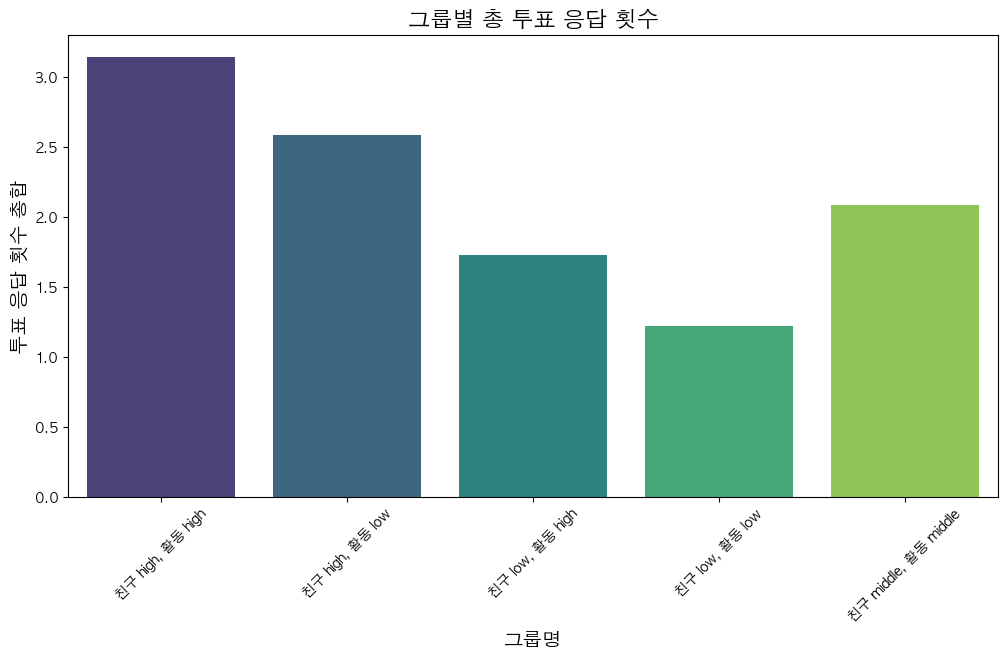

In [ ]:
# 그룹별 count 값의 합계 계산
group_sum = group_summary.groupby('groupname')['count'].sum().reset_index()

# 바 차트 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')

# 그래프 제목 설정
plt.title('그룹별 총 투표 응답 횟수', fontsize=16)
plt.xlabel('그룹명', fontsize=14)
plt.ylabel('투표 응답 횟수 총합', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()

2) 투표 받은 횟수

In [ ]:
#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
v_acc_uqrec['created_at'] = pd.to_datetime(v_acc_uqrec['created_at'])
filtered_uqrec= v_acc_uqrec[v_acc_uqrec['created_at'] < cutoff_date]

#투표에 뽑힌 user_id만 추출
filtered_uqrec_ch = filtered_uqrec[['chosen_user_id']]

#투표에 뽑힌 횟수
chosen_vote_count = filtered_uqrec_ch.value_counts('chosen_user_id').reset_index()

#컬럼 이름 변경
chosen_vote_count = chosen_vote_count.rename(columns = {'chosen_user_id':'user_id'})

#데이터 셋 합치기
chosen_vote_merge = pd.merge(use_df, chosen_vote_count, on ='user_id',how = 'left')

#null값에 0넣기
chosen_vote_merge = chosen_vote_merge.fillna(0)

In [ ]:
group_avg

,groupname,count
0,"친구 high, 활동 high",2.130020
1,"친구 high, 활동 low",2.664003
2,"친구 low, 활동 high",0.823876
3,"친구 low, 활동 low",0.919603
4,"친구 middle, 활동 middle",1.539207


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/1177466083.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')


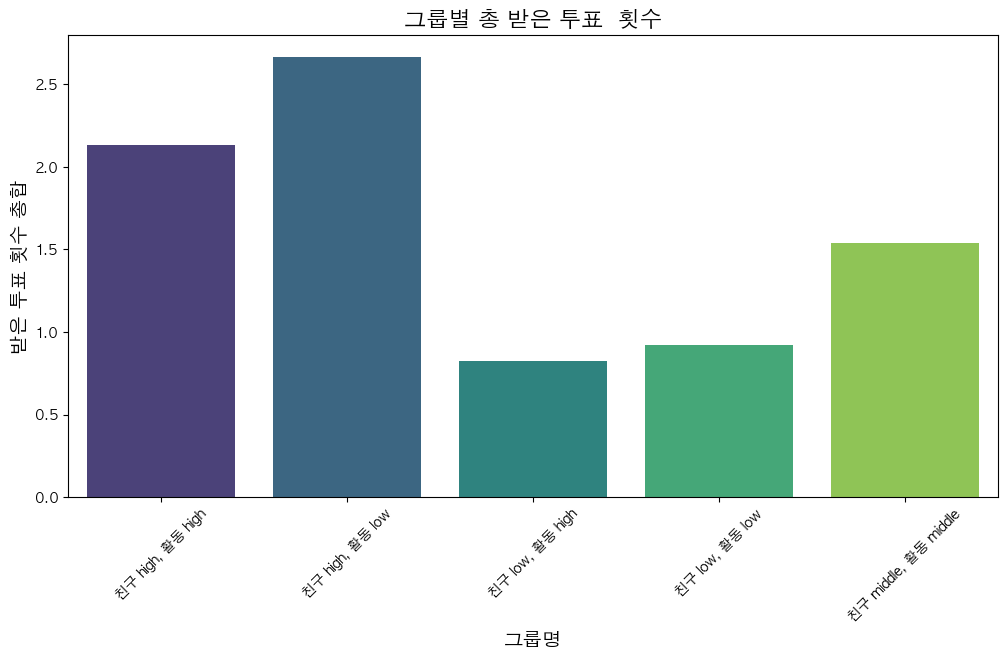

In [ ]:
# 그룹별 평균 응답 횟수 계산
group_avg = chosen_vote_merge.groupby('groupname')['count'].mean().reset_index()


# 바 차트 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')

# 그래프 제목 설정
plt.title('그룹별 총 받은 투표  횟수', fontsize=16)
plt.xlabel('그룹명', fontsize=14)
plt.ylabel('받은 투표 횟수 총합', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()

3. 투표 관련 행동
  - 투표를 한 횟수에 2배 가중치를 두어 계산

In [ ]:
#컬럼 이름 변경
chosen_vote_merge = chosen_vote_merge.rename(columns = {'count':'passive_count'})

#컬럼 이름 변경
vote_merge = vote_merge.rename(columns = {'count':'active_count'})

#두 데이터 셋 합치기
all_vote_df = pd.merge(vote_merge, chosen_vote_merge, on = ['user_id','groupname'], how = 'inner')

#투표를 한 횟수에 2배 가중치 부여하여 투표 관련 행동 횟수 컬럼 생성
all_vote_df['total_count'] = all_vote_df['active_count']*2+all_vote_df['passive_count']

In [ ]:
all_vote_df

,user_id,groupname,active_count,passive_count,total_count
0,832151,"친구 low, 활동 low",0.0,0.0,0.0
1,832340,"친구 high, 활동 low",0.0,0.0,0.0
2,832986,"친구 low, 활동 low",0.0,0.0,0.0
3,833041,"친구 high, 활동 high",0.0,0.0,0.0
4,833154,"친구 high, 활동 low",0.0,0.0,0.0
...,...,...,...,...,...
303234,1575079,"친구 high, 활동 low",0.0,0.0,0.0
303235,1575080,"친구 low, 활동 low",0.0,0.0,0.0
303236,1575082,"친구 low, 활동 low",0.0,0.0,0.0
303237,1575092,"친구 low, 활동 low",0.0,0.0,0.0


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/3178945001.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_avg_all, x='groupname', y='total_count', palette='viridis')


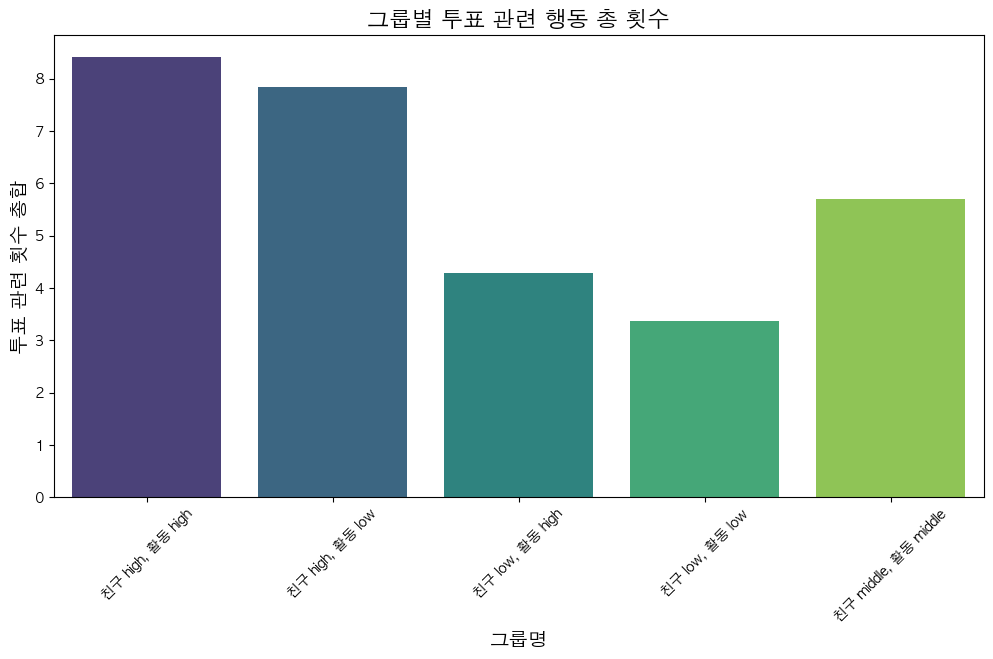

In [ ]:
# 그룹별 평균 응답 횟수 계산
group_avg_all = all_vote_df.groupby('groupname')['total_count'].mean().reset_index()


# 바 차트 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=group_avg_all, x='groupname', y='total_count', palette='viridis')

# 그래프 제목 설정
plt.title('그룹별 투표 관련 행동 총 횟수', fontsize=16)
plt.xlabel('그룹명', fontsize=14)
plt.ylabel('투표 관련 횟수 총합', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()

4. 결제 관련

In [ ]:
#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at'])
filtered_pay= v_acc_pay[v_acc_pay['created_at'] < cutoff_date]

#user_id별로 결제 횟수 카운트
pay_cnt = filtered_pay.value_counts('user_id').reset_index(name = 'pay_count')

# 데이터 합치기
pay_merge = pd.merge(use_df, pay_cnt, on = 'user_id', how = 'left')
pay_merge = pay_merge.fillna(0)

# groupname별로 pay_count의 평균과 총합 계산
group_pay = pay_merge.groupby('groupname')['pay_count'].agg(['mean', 'sum']).reset_index()
group_pay

,groupname,mean,sum
0,"친구 high, 활동 high",0.314663,15859.0
1,"친구 high, 활동 low",0.194089,13989.0
2,"친구 low, 활동 high",0.213030,10771.0
3,"친구 low, 활동 low",0.117653,8858.0
4,"친구 middle, 활동 middle",0.216484,11888.0


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/2234834931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_pay, x='groupname', y='mean', palette='viridis')


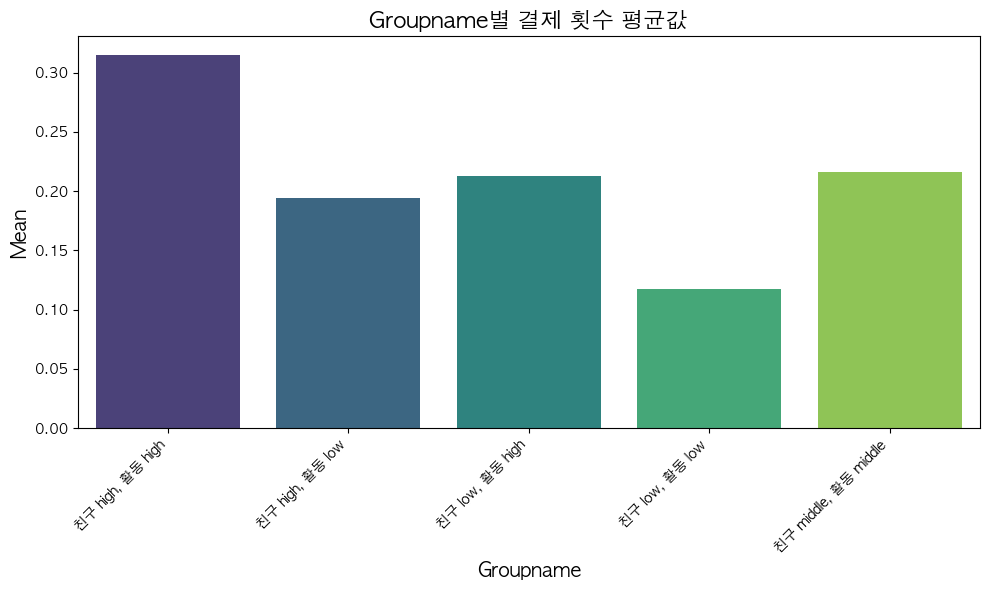

In [ ]:
# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=group_pay, x='groupname', y='mean', palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('Groupname별 결제 횟수 평균값', fontsize=16)
plt.xlabel('Groupname', fontsize=14)
plt.ylabel('Mean', fontsize=14)

# x축 라벨 회전 (너무 긴 텍스트를 보이기 위해)
plt.xticks(rotation=45, ha='right')

# 그래프 출력
plt.tight_layout()
plt.show()

5. 힌트 사용 관련

In [ ]:
#필요한 컬럼 가져오기
hint_df = v_acc_uqrec[['created_at','chosen_user_id','status']]

#6월 13일 이전만 필터링
hint_df['created_at'] = pd.to_datetime(hint_df['created_at'])
filtered_hint = hint_df[hint_df['created_at']<cutoff_date]

# 각 chosen_user_id별로 질문 받은 횟수 (행 개수)와 status가 'I'인 횟수 (오픈 횟수)를 계산
hint_df = filtered_hint.groupby('chosen_user_id').agg(
    question_count=('chosen_user_id', 'size'),  # 질문 받은 횟수
    open_count=('status', lambda x: (x == 'I').sum())  # status가 'I'인 횟수
).reset_index()

#컬럼이름 바꾸기
hint_df = hint_df.rename(columns = {'chosen_user_id':'user_id'})

#데이터 합치기
hint_merge = pd.merge(use_df, hint_df, on = 'user_id', how = 'left')

# null값 채우기
hint_merge = hint_merge.fillna(0)

#그룹합 계산
group_hint = hint_merge.groupby('groupname').agg(
    total_question_count=('question_count', 'sum'),
    total_open_count=('open_count', 'sum')
).reset_index()
group_hint


In [ ]:
group_hint['hint_open_probability'] = group_hint['total_open_count']/group_hint['total_question_count']
group_hint

,groupname,total_question_count,total_open_count,hint_open_probability
0,"친구 high, 활동 high",107353.0,6507.0,0.060613
1,"친구 high, 활동 low",192008.0,9083.0,0.047305
2,"친구 low, 활동 high",41656.0,4255.0,0.102146
3,"친구 low, 활동 low",69236.0,4676.0,0.067537
4,"친구 middle, 활동 middle",84524.0,5641.0,0.066738


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/3955982860.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_hint, x='groupname', y='hint_open_probability', palette='viridis')


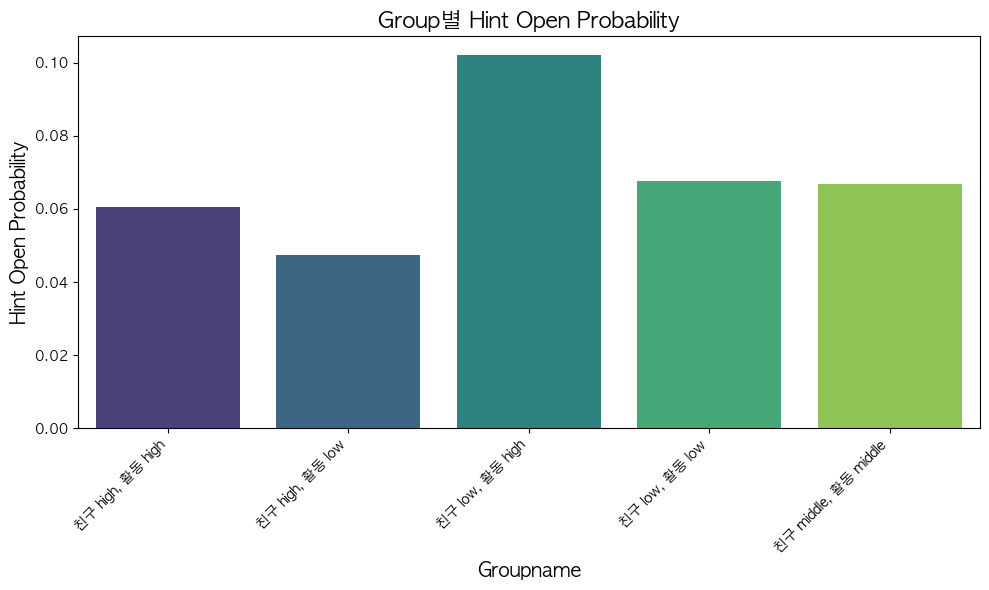

In [ ]:
# 힌트 오픈 확률에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(data=group_hint, x='groupname', y='hint_open_probability', palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('Group별 Hint Open Probability', fontsize=16)
plt.xlabel('Groupname', fontsize=14)
plt.ylabel('Hint Open Probability', fontsize=14)

# x축 라벨 회전 (긴 텍스트를 보이기 위해)
plt.xticks(rotation=45, ha='right')

# 그래프 출력
plt.tight_layout()
plt.show()

6. 성별과 푸쉬 알람

In [ ]:
#필요한 컬럼만 가져오기
user_info = v_acc_user[['id','gender','is_push_on']]

#컬럼 이름 변경
user_info = user_info.rename(columns = {'id':'user_id'})

#데이터 합치기
user_merge = pd.merge(use_df, user_info, on = 'user_id', how = 'left')

# groupname별로 여성 수, 남성 수, 알람을 켰는지(1), 껐는지(0) 횟수 계산
group_info = user_merge.groupby('groupname').agg(
    female_count=('gender', lambda x: (x == 'F').sum()),  # 여성 수
    male_count=('gender', lambda x: (x == 'M').sum()),  # 남성 수
    push_on_count=('is_push_on', lambda x: (x == 1).sum()),  # 알람 켰을 때의 횟수
    push_off_count=('is_push_on', lambda x: (x == 0).sum())  # 알람 껐을 때의 횟수
).reset_index()

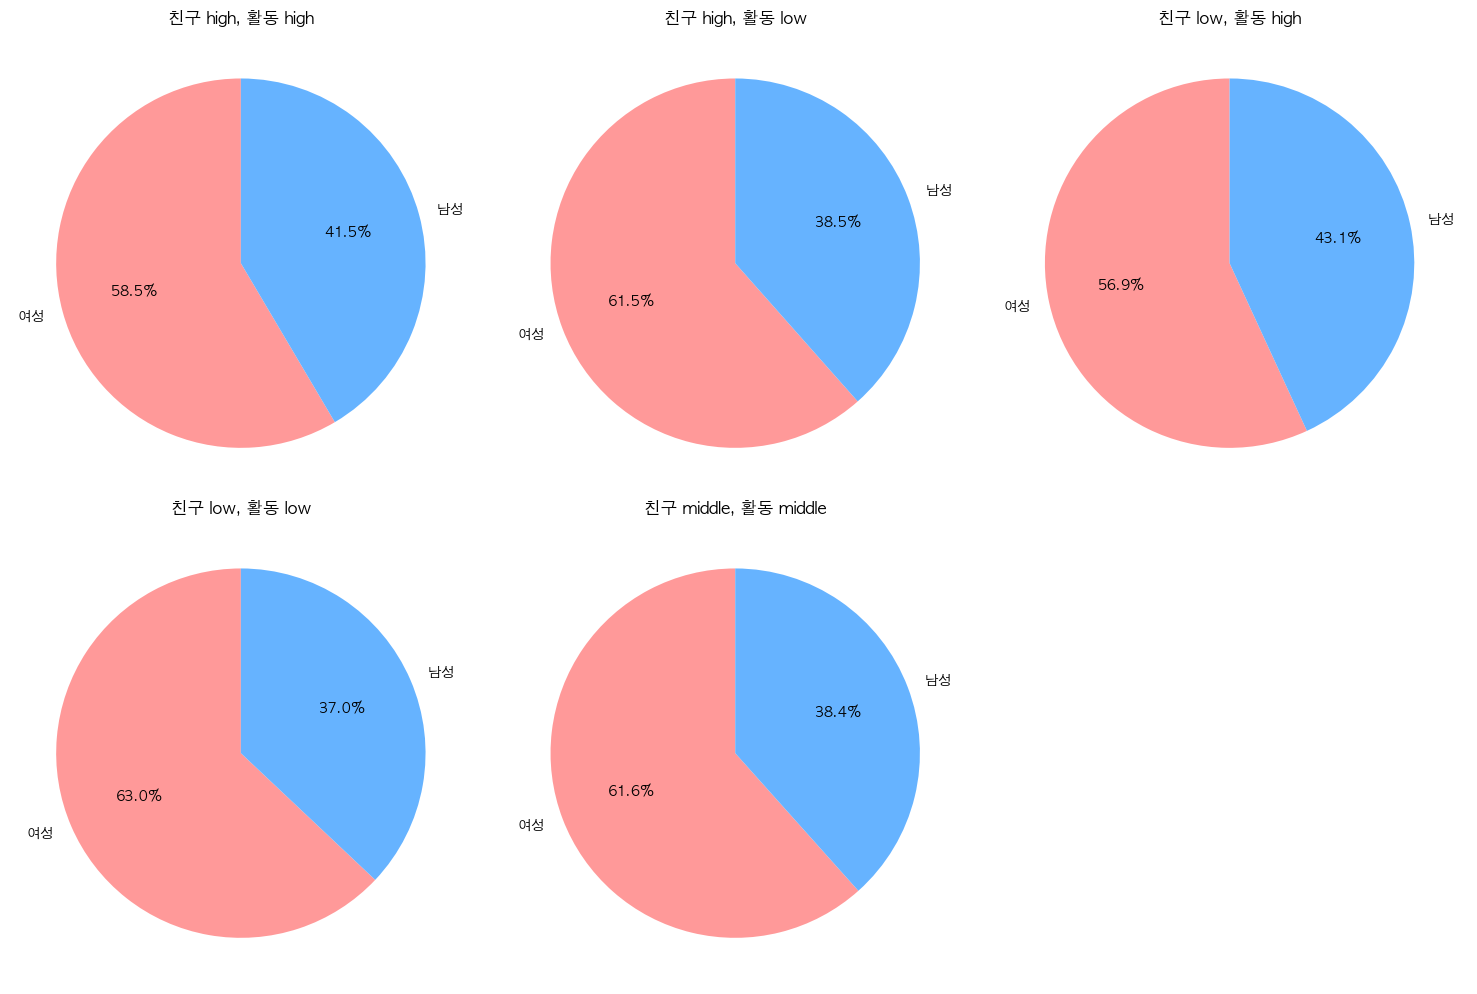

In [ ]:
# 여성과 남성 비율을 계산
group_info['female_ratio'] = group_info['female_count'] / (group_info['female_count'] + group_info['male_count'])
group_info['male_ratio'] = group_info['male_count'] / (group_info['female_count'] + group_info['male_count'])

# 전체 차트 크기 설정
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 각 그룹별로 파이차트를 그리기
for i, ax in enumerate(axes.flat):
    if i < len(group_info):  # 그룹이 부족할 경우에는 빈 공간을 피하기 위해 조건 추가
        # 각 그룹에 대한 여성과 남성 비율 파이차트
        labels = ['여성', '남성']
        sizes = [group_info.loc[i, 'female_ratio'], group_info.loc[i, 'male_ratio']]
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
        ax.set_title(group_info.loc[i, 'groupname'])
    else:
        ax.axis('off')  # 빈 공간에 대해 차트 비활성화

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()

/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/1405062985.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_info, x='groupname', y='push_on_ratio', palette='Set2')


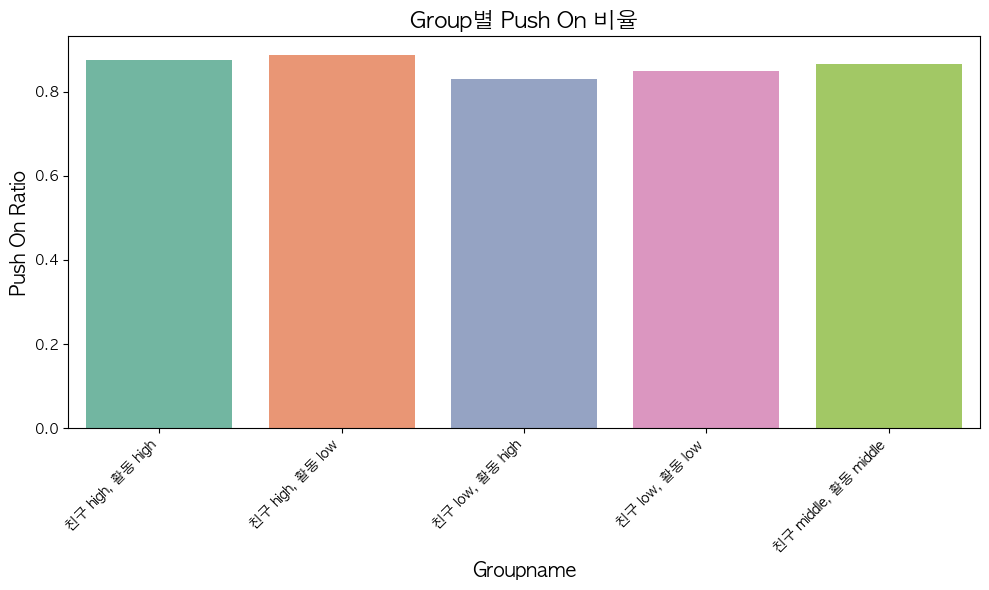

In [ ]:
# push_on 비율 계산
group_info['push_on_ratio'] = group_info['push_on_count'] / (group_info['push_on_count'] + group_info['push_off_count'])

# 그래프 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 그리기
sns.barplot(data=group_info, x='groupname', y='push_on_ratio', palette='Set2')

# 그래프 제목 및 레이블 설정
plt.title('Group별 Push On 비율', fontsize=16)
plt.xlabel('Groupname', fontsize=14)
plt.ylabel('Push On Ratio', fontsize=14)

# x축 라벨 회전
plt.xticks(rotation=45, ha='right')

# 그래프 출력
plt.tight_layout()
plt.show()

7. 그룹별 이탈률

In [ ]:
#필요한 데이터 불러오기
max_interval = pd.read_csv('/Users/goayun/Desktop/고급프로젝트/data/가공 데이터/atd_user_df.csv')

#필요한 컬럼만 사용
use_max_interval_df = max_interval[['user_id','avg_interval','is_breakaway_plenty']]

#데이터 복사
interval_df = use_df.copy()

#데이터 합치기
interval_merge = pd.merge(interval_df, use_max_interval_df, on ='user_id', how = 'left')

#null값 제거
filter_interval = interval_merge.dropna()

# 그룹별 이탈자(True)와 이탈 안한 사람(False)의 수 세기
group_counts = filter_interval.groupby(['groupname', 'is_breakaway_plenty']).size().unstack(fill_value=0)

# 그룹별 avg_interval의 평균 구하기
avg_interval_mean = filter_interval.groupby('groupname')['avg_interval'].mean()

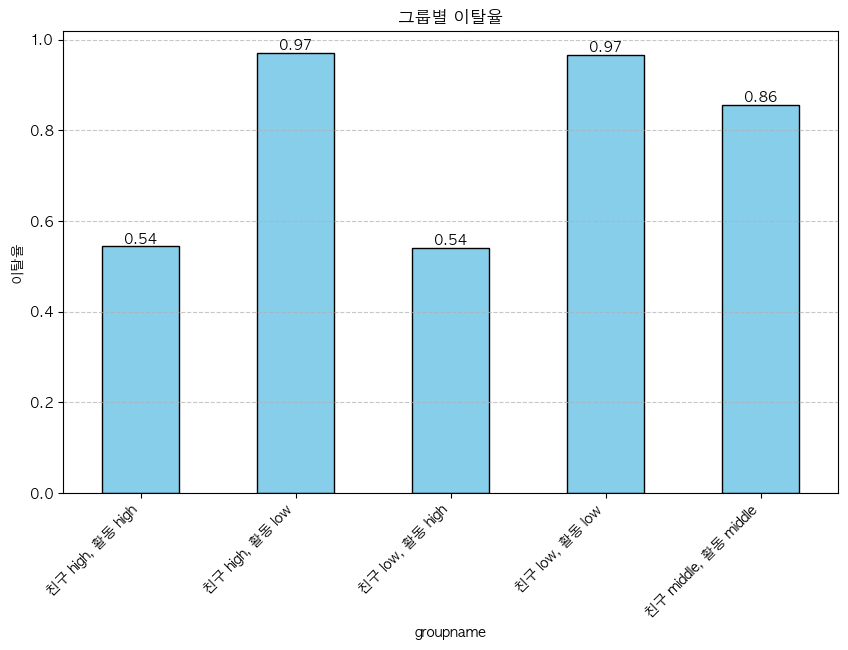

In [ ]:
# 전체 사람 수와 이탈자 수 계산
total_counts = group_counts.sum(axis=1)  # 각 그룹의 전체 인원 수
breakaway_counts = group_counts[True]  # 각 그룹의 이탈자 수

# 이탈율 계산
breakaway_rate = breakaway_counts / total_counts

# 시각화
plt.figure(figsize=(10, 6))
breakaway_rate.plot(kind='bar', color='skyblue', edgecolor='black')  # 세로 막대그래프
plt.ylabel('이탈율')  # y축 라벨
plt.title('그룹별 이탈율')
plt.xticks(rotation=45, ha='right')  # x축 라벨 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y축 그리드 추가

# 이탈율 값 텍스트로 표시
for index, value in enumerate(breakaway_rate):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

3) 그룹별 공유수

In [ ]:
# 필요한 데이터 로드
h_evt_df = pd.read_csv("../h_evt_userid.csv")
user_df_group = pd.read_csv("../user_df_group.csv", encoding='utf-8-sig')

# 해클 데이터 날짜 컬럼 생성성
h_evt_df['event_datetime'] = pd.to_datetime(h_evt_df['event_datetime'])
h_evt_df['event_datetime'] = h_evt_df['event_datetime'].dt.date

# 투표 받은 수 구하는 df 생성
elected_df = h_evt_df[['user_id','event_datetime', 'votes_count']].reset_index(drop=True).drop_duplicates()

# user_id별로 가장 최근 event_datetime의 행만 남기기
latest_rows = elected_df.loc[elected_df.groupby('user_id')['event_datetime'].idxmax()]

# user_id별 투표 받은 수
latest_rows.head(2)

#그룹별 user_id list
# 열정적인 작가
enthu_writer = user_df_group[user_df_group['groupname'] == '열정적인 작가']['user_id'].unique()
# 인기쟁이 수집가
popul_collector = user_df_group[user_df_group['groupname'] == '인기쟁이 수집가']['user_id'].unique()
# 호기심 많은 탐험가
curious_explorer = user_df_group[user_df_group['groupname'] == '호기심 많은 탐험가']['user_id'].unique()
# 여유로운 마을 지킴이
protector = user_df_group[user_df_group['groupname'] == '여유로운 마을 지킴이']['user_id'].unique()
# 잠꾸러기 여행자
sleepy_traveler = user_df_group[user_df_group['groupname'] == '잠꾸러기 여행자']['user_id'].unique()

# 공유 수가 들어 있는 df
share_df = h_evt_df[h_evt_df['event_key'] == 'click_question_share']

def cnt_share(group):
  cnt = share_df[share_df['user_id'].isin(group)].shape[0]
  elected_cnt = latest_rows[latest_rows['user_id'].isin(group)]['votes_count'].sum()
  percentage_population = round(cnt / len(group)*100,2)
  percentage_election = round(cnt/elected_cnt* 100,2)
  print(f"공유수: {cnt}")
  print(f"그룹 사용자 수 대비 공유 수 비율: {percentage_population}%")
  print(f"받은 질문 수 대비 공유 수 비율: {percentage_election}%")


# 결과
print("[열정적인 작가]")
cnt_share(enthu_writer)
print("")

print("[인기쟁이 수집가]")
cnt_share(popul_collector)
print("")

print("[호기심 많은 탐험가]")
cnt_share(curious_explorer)
print("")

print("[여유로운 마을 지킴이]")
cnt_share(protector)
print("")

print("[잠꾸러기 여행자]")
cnt_share(sleepy_traveler)

[열정적인 작가]
공유수: 14394
그룹 사용자 수 대비 공유 수 비율: 23.14%
받은 질문 수 대비 공유 수 비율: 0.12%

[인기쟁이 수집가]
공유수: 5442
그룹 사용자 수 대비 공유 수 비율: 9.57%
받은 질문 수 대비 공유 수 비율: 0.07%

[호기심 많은 탐험가]
공유수: 10464
그룹 사용자 수 대비 공유 수 비율: 17.88%
받은 질문 수 대비 공유 수 비율: 0.22%

[여유로운 마을 지킴이]
공유수: 6562
그룹 사용자 수 대비 공유 수 비율: 9.45%
받은 질문 수 대비 공유 수 비율: 0.1%

[잠꾸러기 여행자]
공유수: 3606
그룹 사용자 수 대비 공유 수 비율: 6.42%
받은 질문 수 대비 공유 수 비율: 0.15%


- 앱 내 행동간 상관관계 분석

In [ ]:
# key 정리
question_event_key = ['click_question_open', 'click_question_share', 'click_question_start','complete_question']
timeline_event_key= ['click_bottom_navigation_timeline', 'view_timeline_tap']
purchase_event_key = ['view_shop', 'complete_purchase', 'click_purchase']
profile_event_key = ['click_bottom_navigation_profile', 'click_copy_profile_link_ask', 'click_copy_profile_link_profile', 'view_profile_tap']
frequency_event_key = ['launch_app']
communication_event_key = ['click_timeline_chat_start', 'click_question_ask', 'click_community_chat', 'click_appbar_chat_rooms', 'click_random_ask_normal', 'click_profile_ask', 'click_random_ask_other']

# key에 있는 값만 event_key에 남김
use_event_key = question_event_key + timeline_event_key + purchase_event_key + profile_event_key + frequency_event_key + communication_event_key
h_evt_df = h_evt_df.drop_duplicates(subset=['user_id', 'event_datetime', 'event_key'])
h_evt_df_filt = h_evt_df[h_evt_df['event_key'].isin(use_event_key)]

# 각 유저의 행동 수 카운트
user_event_counts = h_evt_df_filt.groupby('user_id')['event_key'].count().reset_index()
user_event_counts.columns = ['user_id', 'event_count']

print(f"전체 user_id 수: {h_evt_df_filt['user_id'].nunique()}")
print(f"80퍼센트 이벤트 수: {len(h_evt_df_filt)*0.8:,.0f}")
n = 18
select_user = user_event_counts[user_event_counts['event_count'] >= n]
print(f"{n}개 이상 이벤트 참여한 유저 수: {select_user['user_id'].nunique():,}")
sct_user_id = set(select_user['user_id'].unique())
see_data = h_evt_df_filt[h_evt_df_filt['user_id'].isin(sct_user_id)]
print(f"이벤트 수: {len(see_data):,.0f}")



# 기준으로 새로운 데이터프레임 만들기
# 수정완료 24-12-19 17:10
# event_key 정리 (중복)
question_event_key = ['click_question_open', 'click_question_share', 'click_question_start','complete_question']
timeline_event_key= ['click_bottom_navigation_timeline', 'view_timeline_tap']
purchase_event_key = ['view_shop', 'complete_purchase', 'click_purchase']
profile_event_key = ['click_bottom_navigation_profile', 'click_copy_profile_link_ask', 'click_copy_profile_link_profile', 'view_profile_tap']
frequency_event_key = ['launch_app']
communication_event_key = ['click_timeline_chat_start', 'click_question_ask', 'click_community_chat', 'click_appbar_chat_rooms', 'click_random_ask_normal', 'click_profile_ask', 'click_random_ask_other']

h_evt_df_filt = h_evt_df[h_evt_df['event_key'].isin(use_event_key)]
user_event_counts = h_evt_df_filt.groupby('user_id')['event_key'].count().reset_index()
user_event_counts.columns = ['user_id', 'event_count']
standard_user_df = user_event_counts[user_event_counts['event_count'] >= 18]
standard_user = set(standard_user_df['user_id'].unique())
h_seg_df = h_evt_df_filt[h_evt_df_filt['user_id'].isin(standard_user)]

In [ ]:
## 필요한 컬럼만 모으기
seg_df = h_seg_df[['user_id','event_datetime','event_key','friend_count']]

# 그룹 매핑
event_groups = {
    "question": question_event_key,
    "timeline": timeline_event_key,
    "purchase": purchase_event_key,
    "profile": profile_event_key,
    "frequency": frequency_event_key,
    "communication": communication_event_key
}

# 각 이벤트 키 그룹에 대해 라벨링
def label_event_group(event):
    for group, keys in event_groups.items():
        if event in keys:
            return group
    return "other"

seg_df["event_group"] = seg_df["event_key"].apply(label_event_group)

# 유저별 행동 횟수와 그룹별 비율 계산
user_event_counts = seg_df.groupby("user_id")["event_group"].value_counts(normalize=True).unstack(fill_value=0)

correlation_matrix = user_event_counts.iloc[:, 1:].corr()

In [ ]:
correlation_matrix

event_group,frequency,profile,purchase,question,timeline
event_group,,,,,
frequency,1.000000,-0.329265,-0.066274,-0.043907,-0.383790
profile,-0.329265,1.000000,-0.064054,-0.621974,0.366158
purchase,-0.066274,-0.064054,1.000000,0.000376,-0.094860
question,-0.043907,-0.621974,0.000376,1.000000,-0.718638
timeline,-0.383790,0.366158,-0.094860,-0.718638,1.000000


In [ ]:
#스피어만 상관계수
#필요한 라이브러리 불러오기
import scipy.stats as stats

In [ ]:
# 프로필 관련 행동과 투표 관련 행동 상관계수 유의성 검정
rho, p_value = stats.spearmanr(user_event_counts['profile'], user_event_counts['question'])

print(f"스피어만 상관계수: {rho}, p-값: {p_value}")

스피어만 상관계수: -0.6656724555023811, p-값: 0.0


In [ ]:
# 투표 관련 행동과 타임라인 관련 행동 상관계수 유의성 검정
rho, p_value = stats.spearmanr(user_event_counts['question'], user_event_counts['timeline'])

print(f"스피어만 상관계수: {rho}, p-값: {p_value}")

스피어만 상관계수: -0.7512869474967553, p-값: 0.0


In [ ]:
# 프로필 관련 행동과 타임라인 관련 행동 상관계수 유의성 검정
rho, p_value = stats.spearmanr(user_event_counts['profile'], user_event_counts['timeline'])

print(f"스피어만 상관계수: {rho}, p-값: {p_value}")

스피어만 상관계수: 0.47639776437829195, p-값: 0.0


## 10. 페르소나별 전략 및 성과 분석

### 호기심 많은 탐험가

#### 데이터셋 준비

In [ ]:
start_date = '2023-05-27'
end_date = '2023-06-12'
elected_date_df = v_acc_uqrec[(v_acc_uqrec['created_at'] >= start_date) & (v_acc_uqrec['created_at'] <= end_date)]
elected_date_df = elected_date_df[['chosen_user_id', 'created_at']]

chosen_user_id = set(elected_date_df['chosen_user_id'])

# 사용자 데이터 user_df에서 호기심 많은 탐험가 추출
df_explorer = user_df[user_df['groupname'] == '호기심 많은 탐험가']
df_explorer_user = set(df_explorer['user_id'])

# push 여부 추출
v_user_df = v_acc_user[['id', 'is_push_on']]
v_user_df = v_user_df[v_user_df['id'].isin(df_explorer_user)]

df_explorer = df_explorer.merge(v_user_df, left_on='user_id', right_on='id', how='left')
df_explorer.drop(columns=['id', 'groupname'], inplace=True)

dfsim_exp = df_explorer[['user_id', 'attendance_count', 'is_push_on']]
df_push = dfsim_exp[dfsim_exp['is_push_on'] == 1]
df_nonpush = dfsim_exp[dfsim_exp['is_push_on'] == 0]

push_explorer_id = set(df_push['user_id'])
nonpush_explorer_id = set(df_nonpush['user_id'])

user_friend_df = v_acc_user[['id', 'friend_id_list']]

push_user_friend_df = user_friend_df[user_friend_df['id'].isin(push_explorer_id)]
nonpush_user_friend_df = user_friend_df[user_friend_df['id'].isin(nonpush_explorer_id)]

push_user_friend_df['friend_id_list'] = push_user_friend_df['friend_id_list'].apply(eval)
push_user_friend_pairs = push_user_friend_df.explode('friend_id_list')
push_user_friend_pairs = push_user_friend_pairs.rename(columns={'id': 'user_id', 'friend_id_list': 'friend_id'})

nonpush_user_friend_df['friend_id_list'] = nonpush_user_friend_df['friend_id_list'].apply(eval)
nonpush_user_friend_pairs = nonpush_user_friend_df.explode('friend_id_list')
nonpush_user_friend_pairs = nonpush_user_friend_pairs.rename(columns={'id': 'user_id', 'friend_id_list': 'friend_id'})

push_friend_user_id = set(push_user_friend_pairs['friend_id'])
nonpush_friend_user_id = set(nonpush_user_friend_pairs['friend_id'])

push_user_friend_pairs = push_user_friend_pairs[push_user_friend_pairs['friend_id'].isin(chosen_user_id)]
nonpush_user_friend_pairs = nonpush_user_friend_pairs[nonpush_user_friend_pairs['friend_id'].isin(chosen_user_id)]

# 투표 날짜 추출
elected_date_df['created_at'] = pd.to_datetime(elected_date_df['created_at']).dt.date
elected_date_df = elected_date_df.drop_duplicates(subset=['chosen_user_id', 'created_at'])

vote_dates_by_user = elected_date_df.groupby('chosen_user_id')['created_at'].agg(list).reset_index()
vote_dates_by_user = vote_dates_by_user.rename(columns={'created_at': 'vote_dates'})

push_user_friend_pairs = push_user_friend_pairs.merge(
    vote_dates_by_user,
    left_on='friend_id',
    right_on='chosen_user_id',
    how='left'
)

nonpush_user_friend_pairs = nonpush_user_friend_pairs.merge(
    vote_dates_by_user,
    left_on='friend_id',
    right_on='chosen_user_id',
    how='left'
)

push_user_friend_pairs.drop(columns=['chosen_user_id'], inplace=True)
push_user_friend_pairs.rename(columns={'vote_dates': 'friend_elected_dates'}, inplace=True)

nonpush_user_friend_pairs.drop(columns=['chosen_user_id'], inplace=True)
nonpush_user_friend_pairs.rename(columns={'vote_dates': 'friend_elected_dates'}, inplace=True)

# 출석일 리스트로 변환
v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date']).dt.date

user_atd_list_df = v_acc_atd.groupby('user_id')['attendance_date'].agg(list).reset_index()
user_atd_list_df = user_atd_list_df.rename(columns={'attendance_date': 'user_atd_dates'})

push_user_friend_pairs = push_user_friend_pairs.merge(
    user_atd_list_df,
    on='user_id',
    how='left'
)
nonpush_user_friend_pairs = nonpush_user_friend_pairs.merge(
    user_atd_list_df,
    on='user_id',
    how='left'
)

# 리스트 간 차집합
def get_date_difference(row):
    if isinstance(row['friend_elected_dates'], list) and isinstance(row['user_atd_dates'], list):
        return sorted(list(set(row['friend_elected_dates']) - set(row['user_atd_dates'])))
    return []

push_user_friend_pairs['push_date'] = push_user_friend_pairs.apply(get_date_difference, axis=1)
nonpush_user_friend_pairs['push_date'] = nonpush_user_friend_pairs.apply(get_date_difference, axis=1)

# 푸쉬알람 가능일수 계산
user_push_dates = push_user_friend_pairs.groupby('user_id')['push_date'].agg(lambda x: sorted(list(set([date for dates in x for date in dates])))).reset_index()
user_push_dates = user_push_dates.rename(columns={'push_date': 'all_push_dates'})

nonpush_user_push_dates = nonpush_user_friend_pairs.groupby('user_id')['push_date'].agg(lambda x: sorted(list(set([date for dates in x for date in dates])))).reset_index()
nonpush_user_push_dates = nonpush_user_push_dates.rename(columns={'push_date': 'all_push_dates'})

user_push_dates['push_day_count'] = user_push_dates['all_push_dates'].str.len()
nonpush_user_push_dates['push_day_count'] = nonpush_user_push_dates['all_push_dates'].str.len()

push_user_df = user_push_dates[['user_id', 'push_day_count']]
nonpush_user_df = nonpush_user_push_dates[['user_id', 'push_day_count']]

user_push_count_df = pd.concat([push_user_df, nonpush_user_df])

df_explorer = df_explorer.merge(user_push_count_df, on='user_id', how='left').fillna(0)
user_push_count_df.head(3)

C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\3096296166.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  push_user_friend_df['friend_id_list'] = push_user_friend_df['friend_id_list'].apply(eval)
C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\3096296166.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonpush_user_friend_df['friend_id_list'] = nonpush_user_friend_df['friend_id_list'].apply(eval)


,user_id,push_day_count
0,834089,3
1,837235,0
2,837703,10


#### 가중치 학습(XGBoost)

클래스 분포:
is_breakaway_plenty
True     0.666204
False    0.333796
Name: proportion, dtype: float64


[I 2025-01-13 02:31:44,727] A new study created in memory with name: no-name-98b2d540-eb9c-44a1-a387-65e79ea82820



SMOTE 적용 후 클래스 분포:
is_breakaway_plenty
True     0.5
False    0.5
Name: proportion, dtype: float64


[I 2025-01-13 02:31:47,376] Trial 0 finished with value: 0.9541823653471131 and parameters: {'learning_rate': 0.25017634198969796, 'n_estimators': 372, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8569325049059617, 'colsample_bytree': 0.6682213485793651, 'gamma': 4.856828560632166}. Best is trial 0 with value: 0.9541823653471131.
[I 2025-01-13 02:31:48,656] Trial 1 finished with value: 0.9615778314224579 and parameters: {'learning_rate': 0.27913629915194577, 'n_estimators': 103, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.8617389552049928, 'colsample_bytree': 0.767236729199478, 'gamma': 3.7179315787386265}. Best is trial 1 with value: 0.9615778314224579.
[I 2025-01-13 02:31:50,789] Trial 2 finished with value: 0.9625468926870543 and parameters: {'learning_rate': 0.16154062935267086, 'n_estimators': 220, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9763428855021654, 'colsample_bytree': 0.8005906302328778, 'gamma': 1.7837205277419144}. Best is trial 2 with va

Best trial:
  AUC: 0.9665
  Best hyperparameters: 
    learning_rate: 0.05886944328000497
    n_estimators: 532
    max_depth: 10
    min_child_weight: 1
    subsample: 0.5699280124411454
    colsample_bytree: 0.734816969856146
    gamma: 0.04537214163648653

Optuna 최적화 모델 성능 평가:
Accuracy: 0.8714
Precision: 0.9169
Recall: 0.8875
F1 Score: 0.9019
ROC AUC: 0.9497


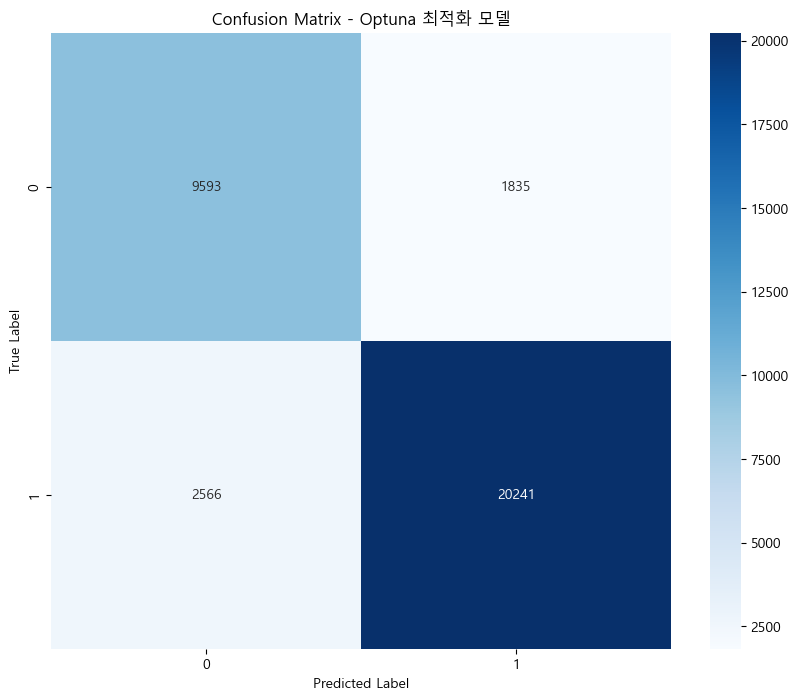

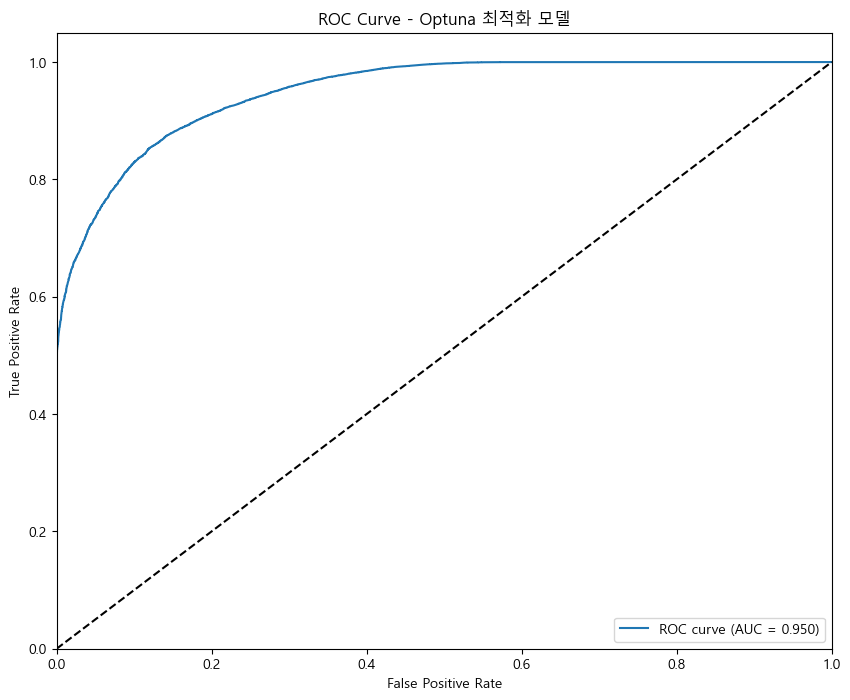

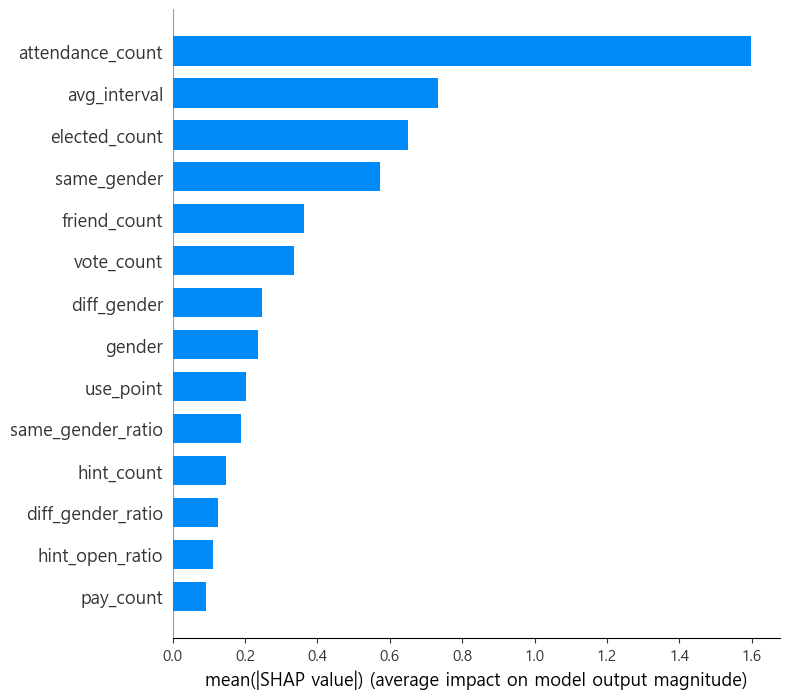

<Figure size 1000x600 with 0 Axes>

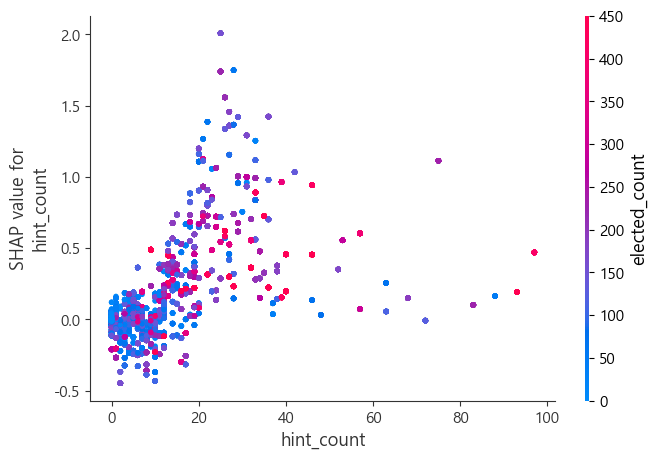

<Figure size 1000x600 with 0 Axes>

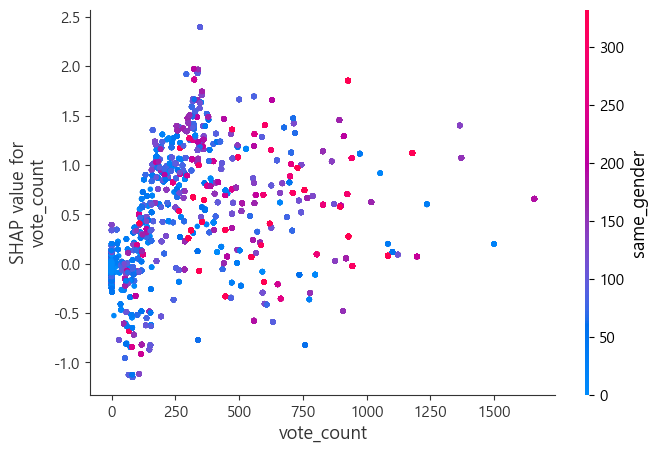

<Figure size 1000x600 with 0 Axes>

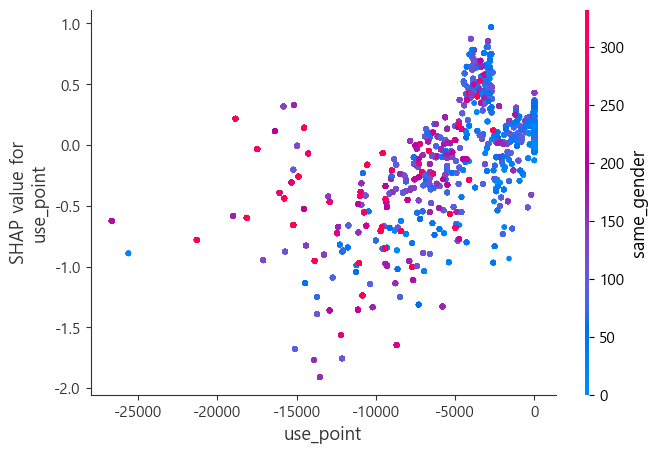

In [ ]:
drop_columns = ['user_id','is_push_on', 'push_day_count']
X = df_explorer.drop(drop_columns + ['is_breakaway_plenty'], axis=1)
y = df_explorer['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("클래스 분포:")
print(y_train.value_counts(normalize=True))

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'tree_method': 'hist',
        'device': 'cuda',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': 1.0,
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

    return auc_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1200)

print("Best trial:")
trial = study.best_trial

print(f"  AUC: {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적 하이퍼파라미터
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['use_label_encoder'] = False
best_params['random_state'] = 42

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# 모델 평가 함수
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} 성능 평가:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return model

evaluate_model(best_model, X_test, y_test, "Optuna 최적화 모델")

# SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# SHAP Dependence Plot
feature_importance = pd.DataFrame({'feature': X.columns,
                                 'importance': best_model.feature_importances_})
top_features = feature_importance.nlargest(3, 'importance')['feature'].values

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_test)
    plt.show()

In [ ]:
booster = best_model.get_booster()
booster.save_model("best_model_explorer.json")

#### 마케팅 시뮬레이션

In [ ]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("best_model_explorer.json")

def increment_attendance(push_day_count):
    """
    push_day_count에 따라 attendance_count를 얼마나 올릴지 결정
    - 1일 땐 +1
    - 2일 땐 +2
    - 3 이상일 땐 round(push_day_count / 3)
    """
    if push_day_count == 1:
        return 1
    elif push_day_count == 2:
        return 2
    else:
        return round(push_day_count / 3)

def marketing_for_push_on(df: pd.DataFrame, random_state=42):
    # push_on 유저 중 푸쉬알람 가능일수가 0일이 아닌 유저들
    condition = (df['is_push_on'] == 1) & (df['push_day_count'] != 0)
    target_users = df[condition]

    # 30% 샘플링
    sample_size = int(len(target_users) * 0.3)
    sampled_users = target_users.sample(n=sample_size, random_state=random_state)

    # attendance_count 증가
    df.loc[sampled_users.index, 'attendance_count'] = (
        df.loc[sampled_users.index, 'attendance_count'] +
        df.loc[sampled_users.index, 'push_day_count'].apply(increment_attendance)
    )

    return df

def marketing_for_push_off(df: pd.DataFrame, random_state=42):
    # push_off 유저 중 푸쉬알람 가능일수가 0일이 아닌 유저들
    condition = (df['is_push_on'] == 0) & (df['push_day_count'] != 0)
    target_users = df[condition]

    # 30% 샘플링
    sample_size = int(len(target_users) * 0.3)
    sampled_users = target_users.sample(n=sample_size, random_state=random_state)

    # attendance_count 증가
    df.loc[sampled_users.index, 'attendance_count'] = (
        df.loc[sampled_users.index, 'attendance_count'] +
        df.loc[sampled_users.index, 'push_day_count'].apply(increment_attendance)
    )

    return df

def run_marketing_scenario(df: pd.DataFrame) -> pd.DataFrame:
    """
    df를 받아 마케팅 시나리오(푸시 ON/OFF에 따른 attendance_count 증가)를 실행한 뒤
    결과를 반환하는 함수
    """
    df_experiment = df.copy()

    # push on 유저
    df_experiment = marketing_for_push_on(df_experiment)

    # push off 유저
    df_experiment = marketing_for_push_off(df_experiment)

    return df_experiment

def multiple_experiments(df_original: pd.DataFrame, model, n_times: int = 1000):
    """
    df_original: 원본 데이터프레임
    model: 불러온 XGBClassifier (loaded_model)
    n_times: 몇 번 반복할지 (default=1000)
    """

    # 예측 결과(예측 라벨, 예측 확률)를 저장할 리스트
    preds_list = []
    proba_list = []

    for i in range(n_times):
        # 마케팅 시나리오 실행
        df_sim = run_marketing_scenario(df_original)

        X_for_prediction = df_sim.drop(['user_id',
                                        'is_breakaway_plenty',
                                        'avg_interval',
                                        'is_push_on',
                                        'push_day_count'], axis=1)

        # 모델 예측
        y_pred = model.predict(X_for_prediction)
        y_pred_proba = model.predict_proba(X_for_prediction)[:, 1]

        preds_list.append(np.mean(y_pred))          # 예측 라벨의 평균
        proba_list.append(np.mean(y_pred_proba))    # 예측 확률의 평균


    overall_pred_mean = np.mean(preds_list)
    overall_proba_mean = np.mean(proba_list)

    return overall_pred_mean, overall_proba_mean

if __name__ == "__main__":
    mean_pred, mean_proba = multiple_experiments(df_explorer, loaded_model, n_times=1000)

    print("호기심 많은 탐험가의 기존 이탈률:", df_explorer['is_breakaway_plenty'].mean().round(4) * 100, "%")
    print("마케팅 1000번 반복 후, 예측 이탈률:", mean_pred.round(4) * 100, "%")
    print("마케팅 1000번 반복 후, 예측 확률:", mean_proba.round(4) * 100, "%")

호기심 많은 탐험가의 기존 이탈률: 58.77 %
마케팅 1000번 반복 후, 예측 이탈률: 57.98 %
마케팅 1000번 반복 후, 예측 확률: 52.18999981880188 %


### 인기쟁이 수집가

#### 데이터셋 준비

In [ ]:
# 앞의 머신러닝에서 사용한 user_df 사용
df_collecter = user_df[user_df['groupname'] == '인기쟁이 수집가']

#### 가중치 학습(XGBoost) - 호기심많은 탐험가와 동일

#### 마케팅 시뮬레이션

In [ ]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("best_model_collecter.json")

def marketing_collecter(df: pd.DataFrame, random_state=42):

    # 30% 샘플링
    sample_size = int(len(df) * 0.1)
    sampled_users = df.sample(n=sample_size, random_state=random_state)

    # attendance_count 증가
    df.loc[sampled_users.index, 'attendance_count'] = (
        df.loc[sampled_users.index, 'attendance_count'] + 1
    )

    return df

def run_marketing_scenario(df: pd.DataFrame) -> pd.DataFrame:
    """
    인기쟁이 수집가의 30%를 대상으로 마케팅 시나리오 진행하는 함수
    """
    df_experiment = df.copy()

    df_experiment = marketing_collecter(df_experiment)

    return df_experiment

def multiple_experiments(df_original: pd.DataFrame, model, n_times: int = 1000):
    """
    df_original: 원본 데이터프레임
    model: 불러온 XGBClassifier (loaded_model)
    n_times: 몇 번 반복할지 (default=1000)
    """

    # 예측 결과(예측 라벨, 예측 확률)를 저장할 리스트
    preds_list = []
    proba_list = []

    for i in range(n_times):
        # 마케팅 시나리오 실행
        df_sim = run_marketing_scenario(df_original)

        X_for_prediction = df_sim.drop(['user_id',
                                        'is_breakaway_plenty',
                                        'avg_interval',
                                        'groupname'], axis=1)

        # 모델 예측
        y_pred = model.predict(X_for_prediction)
        y_pred_proba = model.predict_proba(X_for_prediction)[:, 1]

        preds_list.append(np.mean(y_pred))          # 예측 라벨의 평균
        proba_list.append(np.mean(y_pred_proba))    # 예측 확률의 평균


    overall_pred_mean = np.mean(preds_list)
    overall_proba_mean = np.mean(proba_list)

    return overall_pred_mean, overall_proba_mean

if __name__ == "__main__":
    mean_pred, mean_proba = multiple_experiments(df_collecter, loaded_model, n_times=1000)

    print("인기쟁이 수집가의 기존 이탈률:", df_collecter['is_breakaway_plenty'].mean().round(4))
    print("마케팅 1000번 반복 후, 예측 이탈률:", mean_pred)
    print("마케팅 1000번 반복 후, 예측 확률:", mean_proba)

인기쟁이 수집가의 기존 이탈률: 0.9797
마케팅 1000번 반복 후, 예측 이탈률: 0.7450307827616532
마케팅 1000번 반복 후, 예측 확률: 0.7111654
